<h1>Práctica de Laboratorio: Análisis de Emociones y Sentimiento</h1>
<p><strong>Máster en Bioinformática y Biología Computacional</strong><br>
<strong>Minería de Texto - Curso 2025-26</strong></p>

<p><strong>Integrantes:</strong> [Gonzalo Santana, Tania] y [Parra Gutiérrez, Daniel]</p>


----

# Introducción
En esta práctica realizamos un análisis cuantitativo del contenido emocional de 
10 obras literarias clásicas disponibles en Project Gutenberg. El objetivo es 
evaluar la viabilidad y precisión de técnicas de Procesamiento del Lenguaje 
Natural (PLN) para la detección automática de emociones en textos literarios.ados.

## Instalación y carga de bibliotecas

In [3]:
# Instalación de dependencias (ejecutar si es necesario)
# !pip install nltk requests matplotlib seaborn pandas

In [38]:
import nltk
import requests
import re           # Para limpiar los textos de las novelas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Descargar recursos necesarios de NLTK
nltk.download('wordnet', quiet=True)                    # WordNet para lematización
nltk.download('omw-1.4', quiet=True)                    # WordNet multilingual (a veces necesario)
nltk.download('punkt', quiet=True)                      # tokenizador de palabras
nltk.download('averaged_perceptron_tagger', quiet=True) # POS tagger clásico
nltk.download('punkt_tab', quiet=True)                  ## Añadido por dani para ¿borrar chunk de abajo? # versión nueva de tablas de puntuación (si sale en el error)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)         # util para versiones nuevas de NLTK 
nltk.download('stopwords', quiet=True)                  # (opcional)

print("Bibliotecas cargadas correctamente")

Bibliotecas cargadas correctamente


## Tarea 1: Cargar el léxico NRC EmoLex (1.5 puntos)

El léxico NRC EmoLex es un recurso fundamental en análisis de sentimientos que asocia 14,182 palabras únicas con 8 emociones básicas (anger, anticipation, disgust, fear, joy, sadness, surprise, trust) y 2 sentimientos polarizados (positive, negative).

La estructura del léxico es la siguiente:
- Formato: palabra TAB emoción TAB asociación (0/1)
- Cada palabra puede tener múltiples emociones asociadas
- Ejemplo: "abandon" → fear, negative, sadness

Para ello, hemos cargado el léxico desde el archivo oficial NRC-Emotion-Lexicon-Wordlevel-v0.92.txt, filtrando solo las asociaciones positivas (valor = 1) y almacenándolas en un diccionario {palabra: [lista_emociones]} para acceso eficiente.

In [39]:
archivo = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
# Preparamos el diccionario
nrc_lexicon = defaultdict(list) 

try:
    with open(archivo, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                word, emotion, association = parts
                if association == '1':
                    nrc_lexicon[word].append(emotion)  # De esta manera almacenamos las emociones en las que sí existe asociación
    
    print(f"Léxico NRC cargado desde archivo con {len(nrc_lexicon)} palabras")

except FileNotFoundError:
    print(f"Archivo no encontrado: {archivo}")

Léxico NRC cargado desde archivo con 6453 palabras


Podemos observar como el proceso fue correcto visualizando el diccionario.

In [40]:
# Mostramos las primeras entradas como ejemplo
print("\nEjemplo de entradas del léxico:")
for word in list(nrc_lexicon.keys())[:5]:
    print(f"  {word}: {nrc_lexicon[word]}")


Ejemplo de entradas del léxico:
  abacus: ['trust']
  abandon: ['fear', 'negative', 'sadness']
  abandoned: ['anger', 'fear', 'negative', 'sadness']
  abandonment: ['anger', 'fear', 'negative', 'sadness', 'surprise']
  abba: ['positive']


## Tarea 2: Extender EmoLex con WordNet (3.0 puntos)

WordNet es una base de datos léxica que organiza palabras en redes semánticas.
Utilizamos cuatro tipos de relaciones para extender el léxico NRC:

1. **Sinónimos**: Palabras con significado similar
   - Ejemplo: "happy" → "glad", "joyful", "cheerful"
   
2. **Hipónimos**: Términos más específicos
   - Ejemplo: "emotion" → "anger", "joy", "fear"
   
3. **Hiperónimos**: Términos más generales
   - Ejemplo: "terrier" → "dog" → "animal"
   
4. **Formas derivadas**: Variaciones morfológicas
   - Ejemplo: "happy" → "happiness", "happily"

El léxico extendido usa tuplas (lemma, POS-tag) como claves en lugar de solo 
palabras, permitiendo distinguir entre "lead" (verbo) y "lead" (sustantivo).

La extensión automática puede generar asociaciones cuestionables. Por ejemplo, "calculator" hereda emociones de "abacus" (trust); "abacus" hereda de "tablet" (computing) y resultado: "calculator" asociado con emociones originalmente de contextos no tecnológicos. Por esta razón, generamos DOS léxicos para comparar:
- **NO extendido**: Solo palabras originales del NRC con POS tags (9,469 entradas)
- **Extendido**: Con todas las relaciones de WordNet (55,155 entradas)

In [41]:
# Diccionarios de conversión entre POS tags
wordnet_to_penn = {
    'n': 'NN',  # sustantivo
    'v': 'VB',  # verbo
    'a': 'JJ',  # adjetivo
    's': 'JJS', # adjetivo superlativo (le añadimos la "S") 
    'r': 'RB',  # adverbio
    'c': 'CC'   # conjunción
}

penn_to_wordnet = {
    'CC': 'c', 'CD': 'c', 'DT': 'c', 'EX': 'c', 'FW': 'x', 'IN': 'c',
    'JJ': 'a', 'JJR': 'a', 'JJS': 's', 'LS': 'c', 'MD': 'v',            # Cambiamos el 'JJS': 'a' por 'JJS': 's'
    'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n',
    'PDT': 'c', 'POS': 'c', 'PRP': 'n', 'PRP$': 'n',
    'RB': 'r', 'RBR': 'r', 'RBS': 'r', 'RP': 'r',
    'SYM': 'x', 'TO': 'c', 'UH': 'x',
    'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
    'WDT': 'c', 'WP': 'n', 'WP$': 'n', 'WRB': 'r', 'X': 'x'
}

In [42]:
def add_to_lexicon(lexicon_dict, key, emotions):
    """
    Añade una entrada al léxico sin duplicar emociones.
    Combina las emociones existentes con las nuevas usando set union.
    Args:
        key: tupla construida con el lemma y el POS-tag de la palabra.
        emotions: emociones correspondientes a la key proporcionada.
    
    Returns:
        dict: Diccionario actualizado {(lemma, POS-tag): [lista_de_emociones]} expandido y sin repeticiones
    """
    if key in lexicon_dict:
        lexicon_dict[key] = list(set(lexicon_dict[key]) | set(emotions))
    else:
        lexicon_dict[key] = emotions

In [43]:
# Generar LÉXICO EXTENDIDO
print("EXTENDIENDO LÉXICO CON WORDNET...")
extended_lexicon = {}

for word, emotions in nrc_lexicon.items():
    synsets = wn.synsets(word)
    
    for synset in synsets:
        wn_pos = synset.pos()
        penn_pos = wordnet_to_penn.get(wn_pos, 'NN')
        
        # 1. Palabra original
        add_to_lexicon(extended_lexicon, (word, penn_pos), emotions)
        
        # 2. Sinónimos
        for lemma in synset.lemmas():
            lemma_name = lemma.name().replace('_', ' ').lower()
            add_to_lexicon(extended_lexicon, (lemma_name, penn_pos), emotions)
            
            # 3. Formas derivadas
            try:
                for related in lemma.derivationally_related_forms():
                    related_pos = related.synset().pos()
                    related_penn = wordnet_to_penn.get(related_pos, 'NN')
                    related_name = related.name().replace('_', ' ').lower()
                    add_to_lexicon(extended_lexicon, (related_name, related_penn), emotions)
            except:
                pass
        
        # 4. Hipónimos
        for hyponym in synset.hyponyms():
            for lemma in hyponym.lemmas():
                hyp_name = lemma.name().replace('_', ' ').lower()
                hyp_pos = wordnet_to_penn.get(hyponym.pos(), 'NN')
                add_to_lexicon(extended_lexicon, (hyp_name, hyp_pos), emotions)
        
        # 5. Hiperónimos
        for hypernym in synset.hypernyms():
            for lemma in hypernym.lemmas():
                hyper_name = lemma.name().replace('_', ' ').lower()
                hyper_pos = wordnet_to_penn.get(hypernym.pos(), 'NN')
                add_to_lexicon(extended_lexicon, (hyper_name, hyper_pos), emotions)

# Ordenamos las emociones para consistencia
for k in extended_lexicon:
    extended_lexicon[k] = sorted(set(extended_lexicon[k]))

print(f"Léxico extendido: {len(nrc_lexicon)} → {len(extended_lexicon)} entradas")



# Generamos el LÉXICO NO EXTENDIDO (solo palabras originales con sus correspondientes POS tags)
print("\nGenerando léxico no extendido (palabras originales con POS)...")

original_lexicon = {}

for word, emotions in nrc_lexicon.items():
    synsets = wn.synsets(word)
    for synset in synsets:
        wn_pos = synset.pos()
        penn_pos = wordnet_to_penn.get(wn_pos, 'NN')
        key = (word, penn_pos)
        if key not in original_lexicon:
            original_lexicon[key] = sorted(set(emotions))

print(f"Léxico no extendido: {len(original_lexicon)} entradas")

# Comparación visual
print("\n" + "-"*70)
print("COMPARACIÓN DE LÉXICOS:")
print("-"*70)
print(f"{'Léxico':<30} {'Entradas':<15} {'Expansión'}")
print("-"*70)
print(f"{'Original (NRC palabras)':<30} {len(nrc_lexicon):<15} {'Base'}")
print(f"{'No extendido (con POS)':<30} {len(original_lexicon):<15} {f'+{len(original_lexicon)-len(nrc_lexicon)}'}")
print(f"{'Extendido (WordNet)':<30} {len(extended_lexicon):<15} {f'+{len(extended_lexicon)-len(nrc_lexicon)}'}")
print("-"*70)

EXTENDIENDO LÉXICO CON WORDNET...
Léxico extendido: 6453 → 55155 entradas

Generando léxico no extendido (palabras originales con POS)...
Léxico no extendido: 9469 entradas

----------------------------------------------------------------------
COMPARACIÓN DE LÉXICOS:
----------------------------------------------------------------------
Léxico                         Entradas        Expansión
----------------------------------------------------------------------
Original (NRC palabras)        6453            Base
No extendido (con POS)         9469            +3016
Extendido (WordNet)            55155           +48702
----------------------------------------------------------------------


Hay mayor cantidad de entradas en el léxico extendido que en el no extendido siendo `55155` y `9469` entradas respectivamente. No obstante, ambos son superiores a las entradas originales. Esto también nos puede indicar que, aunque pequeña, existe la posibilidad de que en el diccionario correspondiente al léxico no extendido, se hayan asociado más emociones a las palabras ya definidas; un suceso que no será tan intenso como seguramente haya ocurrido en el diccionario de léxico extendido.

### Comparación entre ambos diccionarios

Podemos comprobar con las primeras entradas del diccionario sin exterder y el diccionarío extendido, cómo varían los lemmas que lo componen y las emociones que se les atribuirían.

In [45]:
# Primeras 10 entradas en el diccionario no expandido
print("\nEjemplo de entradas del léxico:")
for word in list(original_lexicon.keys())[:10]:
    print(f"  {word}: {original_lexicon[word]}")
    
# Primeras 10 entradas en el diccionario expandido 
print("\nEjemplos del léxico extendido:")
for key in list(extended_lexicon.keys())[:10]:
    print(f"  {key}: {extended_lexicon[key]}")



Ejemplo de entradas del léxico:
  ('abacus', 'NN'): ['trust']
  ('abandon', 'NN'): ['fear', 'negative', 'sadness']
  ('abandon', 'VB'): ['fear', 'negative', 'sadness']
  ('abandoned', 'VB'): ['anger', 'fear', 'negative', 'sadness']
  ('abandoned', 'JJS'): ['anger', 'fear', 'negative', 'sadness']
  ('abandonment', 'NN'): ['anger', 'fear', 'negative', 'sadness', 'surprise']
  ('abbot', 'NN'): ['trust']
  ('abduction', 'NN'): ['fear', 'negative', 'sadness', 'surprise']
  ('aberrant', 'NN'): ['negative']
  ('aberrant', 'JJS'): ['negative']

Ejemplos del léxico extendido:
  ('abacus', 'NN'): ['positive', 'trust']
  ('tablet', 'NN'): ['positive', 'trust']
  ('calculator', 'NN'): ['anger', 'disgust', 'fear', 'negative', 'positive', 'sadness', 'trust']
  ('calculating machine', 'NN'): ['anger', 'disgust', 'fear', 'negative', 'positive', 'sadness', 'trust']
  ('abandon', 'NN'): ['anticipation', 'fear', 'joy', 'negative', 'positive', 'sadness', 'trust']
  ('wantonness', 'NN'): ['anger', 'disgus

Como era de esperar, las primeras 10 entradas no son exactamente las mismas entre ambos léxicos. Aquellos lemmas coincidentes entre ambos, tienen muchas más emociones asociadas en el léxico extendido, debido a que se han adquirdo las emociones de sinónimos, hipónimos, hiperhónimos y palabras derivadas. Esto puede causar incongruencias y un análisis que, aunque realizado con un léxico más rico y variado, contenga resultados que no representen con fidelidad las emociones asociadas al texto.

## Tarea 3: Cargar novelas de Project Gutenberg (1.5 puntos)

Project Gutenberg ofrece acceso libre a miles de obras literarias clásicas en 
dominio público.Descargamos  10 novelas representativas de diferentes géneros 
y períodos literario
ado:
- **Psicológica**: Crime and Punishment (Dostoyevsky)
- **Épica**: War and Peace (Tolstoy)
- **Romántica**: Pride and Prejudice (Austen)
- **Gótica**: Frankenstein (Shelley)
- **Detective**: The Adventures of Sherlock Holmes (Conan Doyle)
- **Modernista**: Ulysses (Joyce)
- **Épica clásica**: The Odyssey (Homer, trad. Butler)
- **Aventura**: Moby Dick (Melville)
- **Poesía épica**: The Divine Comedy (Dante, trad. Cary)
- **Filosófica**: Critias (Plato,
 trad. Jowett)
Para ello utilizamos una función proporcionada por el profesor que descargue los textos y otra que los depure con el fin de delimitar el texto de interes y homogeneizarlo para facilitar su  El proceso se basa en:

1. Descarga automática vía HTTP
2. Eliminación de headers/footers de Gutenberg
3. Normalización de espacios y caracteres de control
4. Homogeneización del formato para procesamiento uniformeprocesamiento.

In [46]:
books = {
    'Crime and Punishment': 'http://www.gutenberg.org/files/2554/2554-0.txt',
    'War and Peace': 'http://www.gutenberg.org/files/2600/2600-0.txt',
    'Pride and Prejudice': 'http://www.gutenberg.org/files/1342/1342-0.txt',
    'Frankenstein': 'https://www.gutenberg.org/cache/epub/84/pg84.txt',
    'The Adventures of Sherlock Holmes': 'http://www.gutenberg.org/files/1661/1661-0.txt',
    'Ulysses': 'http://www.gutenberg.org/files/4300/4300-0.txt',
    'The Odyssey': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
    'Moby Dick': 'http://www.gutenberg.org/files/15/15-0.txt',
    'The Divine Comedy': 'https://www.gutenberg.org/cache/epub/8800/pg8800.txt',
    'Critias': 'https://www.gutenberg.org/cache/epub/1571/pg1571.txt'
}

In [47]:
def download_text(url):
    """
    Descarga el texto de una novela en formato txt.
    
    Args:
        url: URL del texto en Project Gutenberg
    
    Returns:
        str: Contenido del texto o None si hay error
    """
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar el texto: {e}")
        return None



def clean_gutenberg_text(text):
    """
    Limpia el texto eliminando el header y footer de Project Gutenberg.
    
    Args:
        text: Texto completo del libro
    
    Returns:
        str: Texto limpio
    """
    # Buscamos inicio y fin del contenido real
    start_markers = ['*** START OF THIS PROJECT GUTENBERG', '*** START OF THE PROJECT GUTENBERG']
    end_markers = ['*** END OF THIS PROJECT GUTENBERG', '*** END OF THE PROJECT GUTENBERG']
    
    start_idx = 0
    for marker in start_markers:
        idx = text.find(marker)
        if idx != -1:
            start_idx = text.find('\n', idx) + 1
            break
    
    end_idx = len(text)
    for marker in end_markers:
        idx = text.find(marker)
        if idx != -1:
            end_idx = idx
            break
    
    cleaned = text[start_idx:end_idx].strip()
    # Elimina saltos de página, caracteres de control y dobles espacios para homogeneizar el texto y facilitar su procesamiento
    cleaned = re.sub(r'\f|\r', ' ', cleaned)      # borra saltos de página (\f) y retornos de carro
    cleaned = re.sub(r'\s+', ' ', cleaned)        # comprime múltiples espacios o saltos de línea

    return cleaned

In [48]:
# Descargamos todas las novelas
book_texts = {}
print("Descargando novelas de Project Gutenberg...\n")

for title, url in books.items():
    print(f"Descargando: {title}...", end=' ')
    text = download_text(url)
    
    if text:
        cleaned_text = clean_gutenberg_text(text)
        book_texts[title] = cleaned_text
        print(f"({len(cleaned_text):,} caracteres)")
    else:
        print("Error")

print(f"\n{len(book_texts)} novelas descargadas correctamente")


Descargando novelas de Project Gutenberg...

Descargando: Crime and Punishment... (1,130,901 caracteres)
Descargando: War and Peace... (3,191,732 caracteres)
Descargando: Pride and Prejudice... (718,465 caracteres)
Descargando: Frankenstein... (418,285 caracteres)
Descargando: The Adventures of Sherlock Holmes... (559,224 caracteres)
Descargando: Ulysses... (1,509,388 caracteres)
Descargando: The Odyssey... (677,098 caracteres)
Descargando: Moby Dick... (1,214,620 caracteres)
Descargando: The Divine Comedy... (603,080 caracteres)
Descargando: Critias... (55,079 caracteres)

10 novelas descargadas correctamente


In [49]:
total_chars = sum(len(text) for text in book_texts.values())
print(f"Total de caracteres: {total_chars:,}")
print(f"Promedio por obra: {total_chars/len(book_texts):,.0f}")
print(f"Obra más larga: {max(book_texts.items(), key=lambda x: len(x[1]))[0]}")
print(f"Obra más corta: {min(book_texts.items(), key=lambda x: len(x[1]))[0]}")

Total de caracteres: 10,077,872
Promedio por obra: 1,007,787
Obra más larga: War and Peace
Obra más corta: Critias


In [ ]:
## Comentar algo de la stadistica??

Tras asegurarnos de que la descarga haya procedido correctamente, procedemos a realizar los pasos 4 y 5. Siendo el análisis (paso 5) primero para la versión del léxico extendido y posteriormente para el léxico no extendido.

## Tarea 4: Analizar emociones en los textos (3.0 puntos)

Implementamos un pipeline de análisis emocional que procesa el texto completo 
de cada novela siguiendo los pasos de: **tokenización** (word_tokenize) donde se divide el texto en palabras individuales y se preserva la puntuación para contexto (futuras mejoras); **POS-Tagging** (pos_tag) donde se identifica la categoría gramatical: verbo, sustantivo, adjetivo, etc. Este paso es crucial para disambiguación: "lead" verbo vs "lead" sustantivo. Posteriormente se lleva a cabo la **lematización** (WordNetLemmatizer) donde se reduce palabras a su forma base ("running", "ran", "runs" → "run") y se mejora el matching con el léxico. Después se **búsca en léxico**, comparando cada tupla (lemma, POS) con el léxico y se registra todas las emociones asociadas. Por último, se lleva a cabo el **conteo y agregación** sumando las frecuencias de cada emoción y generando un perfil emocional por obra.

Se analizará el texto COMPLETO  y se silencian los warnings de POS desconocidos.

In [50]:
def get_wordnet_pos(penn_tag):
    """Convierte POS tag Penn → WordNet"""
    return penn_to_wordnet.get(penn_tag, 'n')

def analyze_emotions(text, lexicon, verbose=False):
    """
    Analiza emociones en un texto usando el léxico proporcionado.
    
    Args:
        text: Texto a analizar
        lexicon: Diccionario {(lemma, pos): [emociones]}
        verbose: Si True, muestra warnings de POS desconocidos
    
    Returns:
        Counter con emociones detectadas
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    pos_tags = pos_tag(tokens)
    emotion_counts = Counter()
    
    for word, penn_pos in pos_tags:
        if not word.isalpha():
            continue
        
        wn_pos = get_wordnet_pos(penn_pos)
        
        try:
            lemma = lemmatizer.lemmatize(word, pos=wn_pos)
            key = (lemma, penn_pos)
            
            if key in lexicon:
                for emotion in lexicon[key]:
                    emotion_counts[emotion] += 1
        
        except KeyError:
            if verbose:
                print(f"  POS desconocido '{wn_pos}' para '{word}'")
            continue
    
    return emotion_counts

def analyze_all_books(book_texts, lexicon, lexicon_name="", use_full_text=True):
    """
    Analiza todas las novelas con el léxico especificado.
    
    Args:
        book_texts: Dict {título: texto}
        lexicon: Léxico a usar
        lexicon_name: Nombre descriptivo del léxico
        use_full_text: Si True, analiza texto completo; si False, solo 100k chars
    
    Returns:
        Dict con resultados por libro
    """
    results = {}
    
    print(f"ANALIZANDO NOVELAS CON LÉXICO {lexicon_name.upper()}")
    for title, text in book_texts.items():
        print(f"{title:<45}", end=' ')
        
        # Usará el texto completo si se indica en la función
        text_to_analyze = text if use_full_text else text[:100000]
        
        emotion_counts = analyze_emotions(text_to_analyze, lexicon, verbose=False)  ## Si se cambia a True se podrán observar las palabras que omiten
        results[title] = emotion_counts
        
        total = sum(emotion_counts.values())
        chars_analyzed = len(text_to_analyze)
        print(f"{total:>6,} emociones ({chars_analyzed:>9,} chars)")
    
    print(f"{'='*70}\n")
    return results

Indicando `verbose=True` podemos observar que aquellas palabras que se omiten son principalmente determinantes, conjunciones y preposiciones; palabras que no cargan con emociones.

Ejecutamos el pipeline dos veces (léxico no extendido y extendido) para evaluar 
el impacto metodológico de la extensión semántica.

In [51]:
# Hacemos el análisis de texto completo con las funciones definidas
# Esto puede tadar 2-3 min
extended_results = analyze_all_books(book_texts, extended_lexicon, "EXTENDIDO", use_full_text=True)
original_results = analyze_all_books(book_texts, original_lexicon, "NO EXTENDIDO", use_full_text=True)

ANALIZANDO NOVELAS CON LÉXICO EXTENDIDO
Crime and Punishment                          256,248 emociones (1,130,901 chars)
War and Peace                                 681,097 emociones (3,191,732 chars)
Pride and Prejudice                           170,073 emociones (  718,465 chars)
Frankenstein                                  104,366 emociones (  418,285 chars)
The Adventures of Sherlock Holmes             132,092 emociones (  559,224 chars)
Ulysses                                       331,690 emociones (1,509,388 chars)
The Odyssey                                   156,468 emociones (  677,098 chars)
Moby Dick                                     244,724 emociones (1,214,620 chars)
The Divine Comedy                             139,070 emociones (  603,080 chars)
Critias                                       10,348 emociones (   55,079 chars)

ANALIZANDO NOVELAS CON LÉXICO NO EXTENDIDO
Crime and Punishment                          33,908 emociones (1,130,901 chars)
War and Peace   

## Tarea 5: Presentar resultados (1.0 puntos)

### Tarea 5.1: Presentar resultados de léxico extendido

En esta sección presentamos los resultados obtenidos mediante visualizaciones 
comparativas y análisis estadístico. El objetivo es evaluar las diferencias cuantitativas entre ambos léxicos así como identificar patrones emocionales por obra y globalmente.

### Análisis estadístico

In [52]:
def create_results_dataframe(analysis_results):
    """
    Crea un DataFrame con los resultados del análisis.
    
    Args:
        analysis_results: Diccionario con resultados por libro
    
    Returns:
        DataFrame: Datos organizados para visualización
    """
    data = []
    
    for book, emotions in analysis_results.items():
        for emotion, count in emotions.items():
            data.append({
                'Book': book,
                'Emotion': emotion,
                'Count': count
            })
    
    return pd.DataFrame(data)

In [53]:
# Creamos un DataFrame
df_results = create_results_dataframe(extended_results)

# Mostramos el resumen estadístico
print("=== RESUMEN ESTADÍSTICO ===\n")

# Total de emociones por libro
print("Total de emociones detectadas por libro:")
for book, emotions in extended_results.items():
    total = sum(emotions.values())
    print(f"  {book}: {total:,}")

print("\n" + "="*50 + "\n")

# Emociones más comunes globalmente
print("Emociones más comunes en todas las novelas:")
all_emotions = Counter()
for emotions in extended_results.values():
    all_emotions.update(emotions)

for emotion, count in all_emotions.most_common(10):
    print(f"  {emotion}: {count:,}")

=== RESUMEN ESTADÍSTICO ===

Total de emociones detectadas por libro:
  Crime and Punishment: 256,248
  War and Peace: 681,097
  Pride and Prejudice: 170,073
  Frankenstein: 104,366
  The Adventures of Sherlock Holmes: 132,092
  Ulysses: 331,690
  The Odyssey: 156,468
  Moby Dick: 244,724
  The Divine Comedy: 139,070
  Critias: 10,348


Emociones más comunes en todas las novelas:
  positive: 312,332
  negative: 269,461
  trust: 266,664
  anticipation: 252,567
  fear: 220,479
  joy: 198,368
  anger: 184,811
  sadness: 180,671
  surprise: 178,564
  disgust: 162,259


### Visualización 1: Emociones por libro

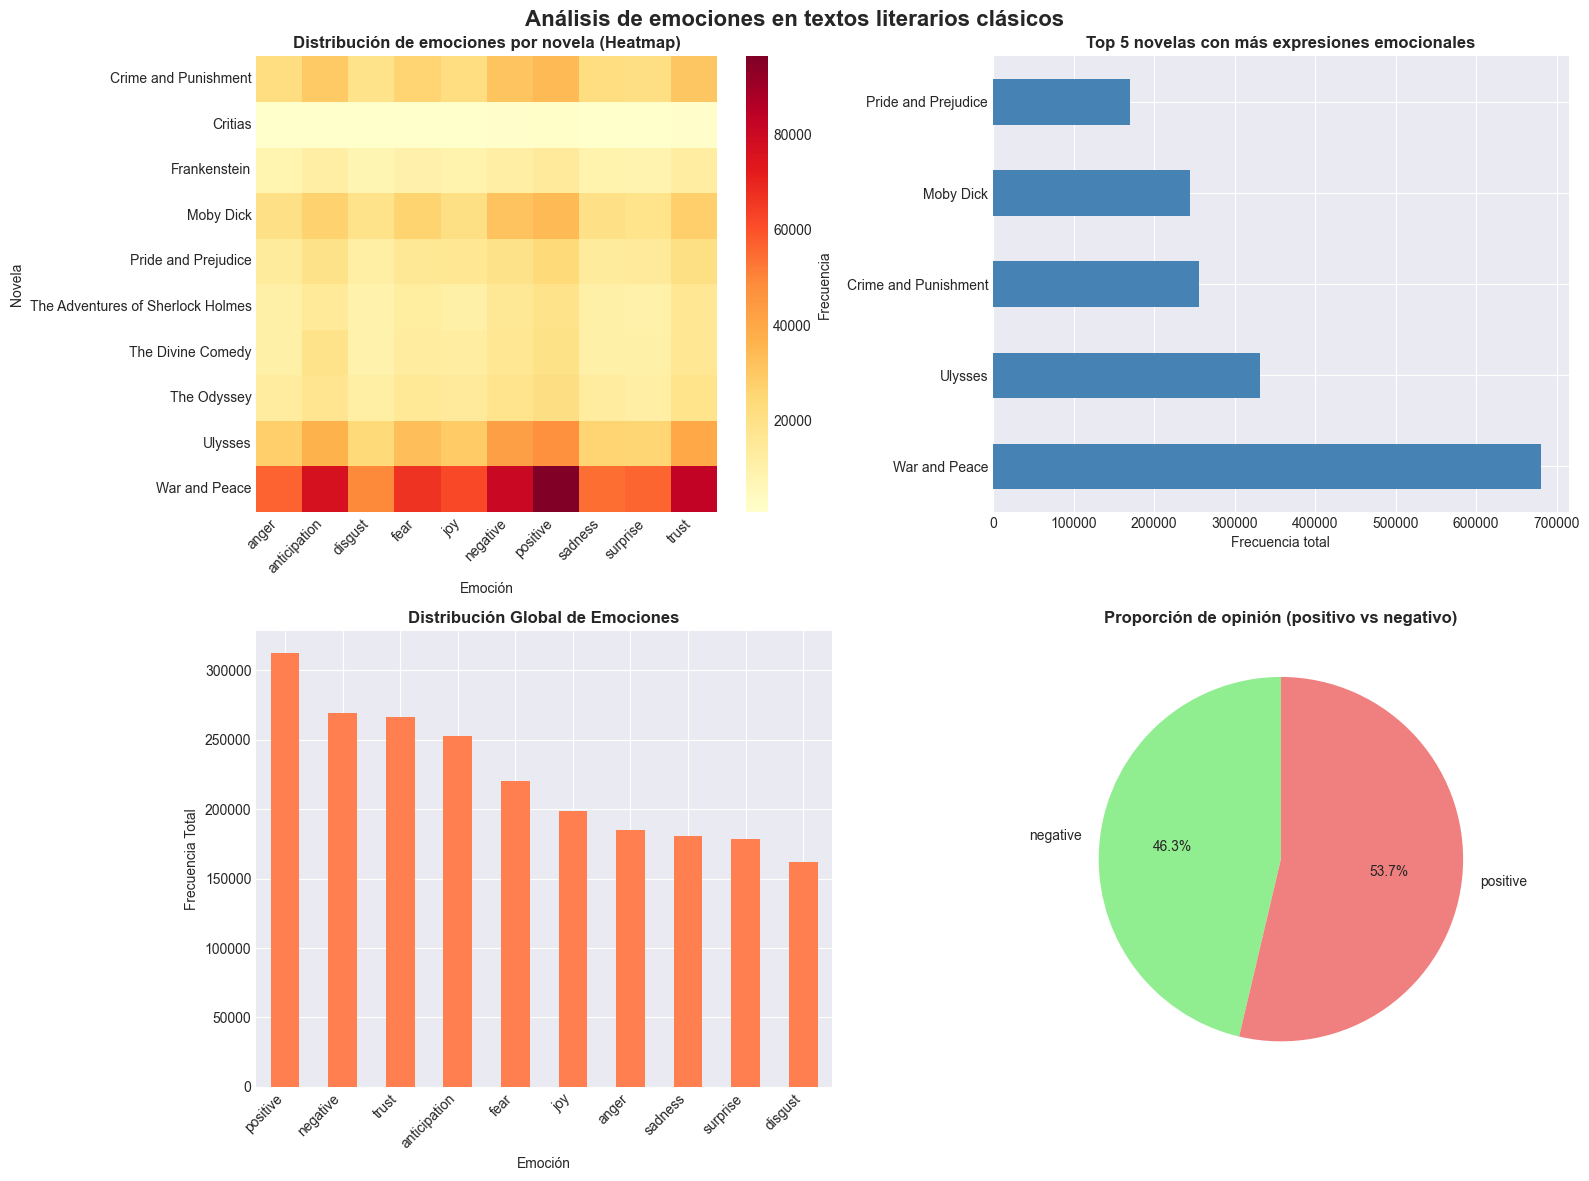

In [54]:
# Configuramos el estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Creamos una figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de emociones en textos literarios clásicos', fontsize=16, fontweight='bold')

# 1. Heatmap de emociones por libro
ax1 = axes[0, 0]
pivot_table = df_results.pivot_table(values='Count', index='Book', columns='Emotion', fill_value=0)
sns.heatmap(pivot_table, annot=False, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Frecuencia'})
ax1.set_title('Distribución de emociones por novela (Heatmap)', fontweight='bold')
ax1.set_xlabel('Emoción')
ax1.set_ylabel('Novela')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# 2. Top 5 libros por total de emociones
ax2 = axes[0, 1]
book_totals = df_results.groupby('Book')['Count'].sum().sort_values(ascending=False).head(5)
book_totals.plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_title('Top 5 novelas con más expresiones emocionales', fontweight='bold')
ax2.set_xlabel('Frecuencia total')
ax2.set_ylabel('')

# 3. Distribución global de emociones
ax3 = axes[1, 0]
emotion_totals = df_results.groupby('Emotion')['Count'].sum().sort_values(ascending=False)
emotion_totals.plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Distribución Global de Emociones', fontweight='bold')
ax3.set_xlabel('Emoción')
ax3.set_ylabel('Frecuencia Total')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Opiniones por categoría (positivas vs negativas)
ax4 = axes[1, 1]
sentiment_data = df_results[df_results['Emotion'].isin(['positive', 'negative'])]
if not sentiment_data.empty:
    sentiment_totals = sentiment_data.groupby('Emotion')['Count'].sum()
    ax4.pie(sentiment_totals, labels=sentiment_totals.index, autopct='%1.1f%%', 
            colors=['lightgreen', 'lightcoral'], startangle=90)
    ax4.set_title('Proporción de opinión (positivo vs negativo)', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No hay datos de sentimiento', ha='center', va='center')
    ax4.set_title('Proporción de opinión', fontweight='bold')

plt.tight_layout()
plt.show()


En la **Figura 1** (superiro izquierda) novelas como "War and Peace" muestran una alta presencia de emociones como "negativo", "positivo", "tristeza" y "confianza". Otras novelas, como "Critias", presentan un perfil emocional más uniforme y menos intenso. 

En la **Figura 2** (supeior derecha) "War and Peace" lidera significativamente el ranking, indicando una mayor riqueza emocional en comparación con las otras novelas. 

La distribución Global de Emociones que se puede observar en la **Figura 3** (inferior izquierda) las emociones "positivo", "negativo", "confianza" y "anticipación" son las más frecuentes en el conjunto de novelas mientras que emociones como "asco" y "sorpresa" son las menos frecuentes. Y con la proporción de opinión (**Figura4**, inferior derecha)queda reflegada que, entre todas las novelas hay prácticamente el mismo porcentaje, siendo la opinión positiva superior por un 7.4%.

Precedemos a analizar las emociones en cada novela

### Visualización 2: Análisis detallado por novela

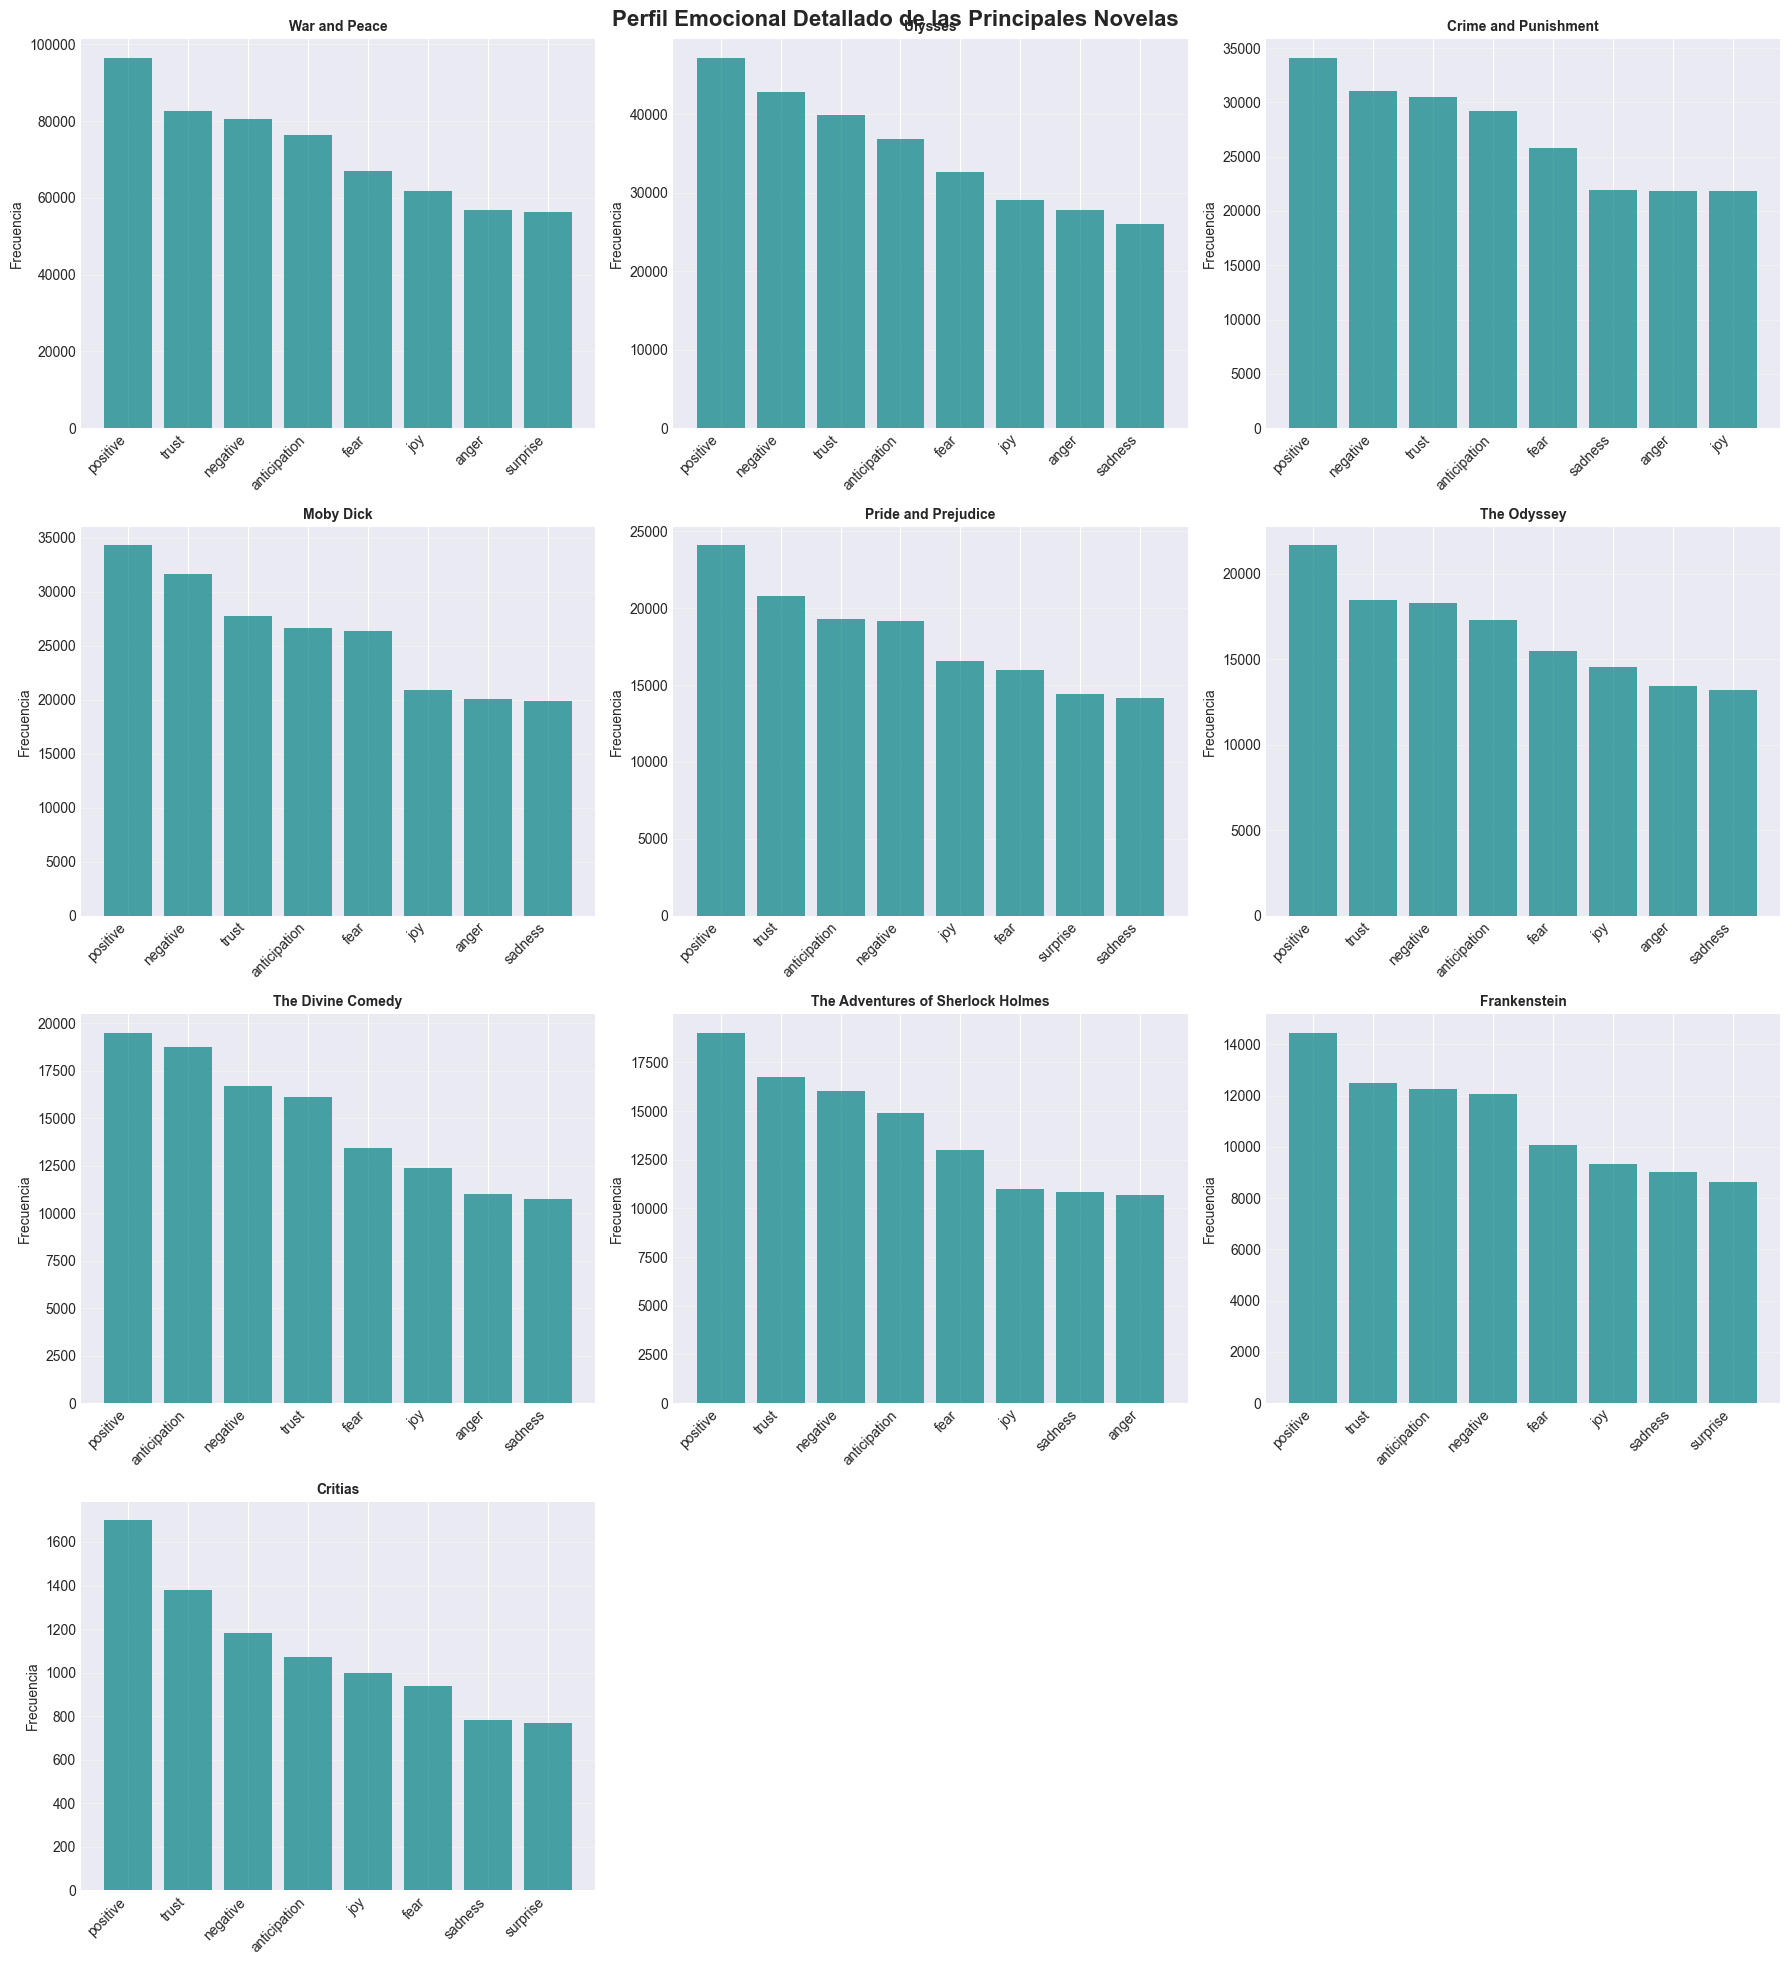

In [62]:
# Creamos gráficos individuales para cada novela (top 5)
all_books = df_results.groupby('Book')['Count'].sum().sort_values(ascending=False).index

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Perfil Emocional Detallado de las Principales Novelas', fontsize=16, fontweight='bold')

for idx, book in enumerate(all_books):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    book_data = df_results[df_results['Book'] == book].sort_values('Count', ascending=False).head(8)
    
    ax.bar(range(len(book_data)), book_data['Count'], color='teal', alpha=0.7)
    ax.set_xticks(range(len(book_data)))
    ax.set_xticklabels(book_data['Emotion'], rotation=45, ha='right')
    ax.set_title(book, fontweight='bold', fontsize=10)
    ax.set_ylabel('Frecuencia')
    ax.grid(axis='y', alpha=0.3)

# Ocultamos el último subplot si no se usa
if len(all_books) < 12:
    axes[3, 2].axis('off')
    axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

Para **"War and Peace"**: predominan "positivo", "confianza" y "negativo" indicando una fuerte presencia de estos sentimientos en la novelamientras que "Ira" y "sorpresa" tienen la menor frecuencia.

En **"Ulysses"** y **"Crime and Punishment"**: de manera similar a "War and Peace", "positivo" lidera, seguido por "negativo" y "confianza", aunque con frecuencias generales más bajas.  Sin emargo, respectiva y contrariamente tienen menor frecuencia "Tristeza" y "Alegria".

**"Moby Dick"** tiene ambas opiniones predominantes: "positivo" y "negativo" seguidos por "Confianza". Esto sugiere una mezcla de opiniones contrastantes en la novela.

En **"Pride and Prejudice"**: "positivo" y "Confianza" tiene una alta presencia, seguida por "Anticipación". "Sorpresa" y "Tristeza" son las menos frecuentes.


## Faltan el resto

Conclusiones Generales:


En general, las emociones "positivo", "negativo" y "confianza" son consistentemente altas en todas las novelas (con la excepción de "La Divina Comedia" con "anticipación en segunda posición"), lo que sugiere que estas emociones son fundamentales en la narrativa literaria clásica.No obstante cada novela tiene su propio perfil emocional distintivo, lo que refleja las diferencias en los temas, personajes y tramas.

#Esto lo quitaría
#Amplitud Emocional: Las novelas con mayor frecuencia total de emociones (como "War and Peace") pueden considerarse más ricas en términos de la variedad y la intensidad de las experiencias emocionales representadas.

Este análisis detallado de cada novela proporciona una visión matizada de cómo las emociones se entrelazan en la narrativa y cómo cada obra literaria crea un paisaje emocional único para sus lectores.

#### Análisis y Conclusiones de Léxico extendido

In [68]:
print(" ANÁLISIS DE PATRONES EMOCIONALES ENCONTRADOS")

# Analizamos qué libro es más emocional
most_emotional_book = max(extended_results.items(), key=lambda x: sum(x[1].values()))
print(f"\nNovela más expresiva emocionalmente:")
print(f"   → {most_emotional_book[0]} ({sum(most_emotional_book[1].values()):,} expresiones)")

# Analizamos la emoción dominante por libro
print(f"\nEmoción dominante por novela:")
for book, emotions in extended_results.items():
    if emotions:
        dominant_emotion = max(emotions.items(), key=lambda x: x[1])
        print(f"   → {book}: {dominant_emotion[0]} ({dominant_emotion[1]:,})")

# Comparamos las opiniones positivas vs negativas
print(f"\nBalance de opinión (positivo vs negativo):")
for book, emotions in extended_results.items():
    positive = emotions.get('positive', 0)
    negative = emotions.get('negative', 0)
    total = positive + negative
    if total > 0:
        pos_ratio = (positive / total) * 100
        print(f"   → {book}: {pos_ratio:.1f}% positivo, {100-pos_ratio:.1f}% negativo")

 ANÁLISIS DE PATRONES EMOCIONALES ENCONTRADOS

Novela más expresiva emocionalmente:
   → War and Peace (681,097 expresiones)

Emoción dominante por novela:
   → Crime and Punishment: positive (34,089)
   → War and Peace: positive (96,418)
   → Pride and Prejudice: positive (24,082)
   → Frankenstein: positive (14,443)
   → The Adventures of Sherlock Holmes: positive (19,018)
   → Ulysses: positive (47,137)
   → The Odyssey: positive (21,672)
   → Moby Dick: positive (34,276)
   → The Divine Comedy: positive (19,498)
   → Critias: positive (1,699)

Balance de opinión (positivo vs negativo):
   → Crime and Punishment: 52.3% positivo, 47.7% negativo
   → War and Peace: 54.5% positivo, 45.5% negativo
   → Pride and Prejudice: 55.7% positivo, 44.3% negativo
   → Frankenstein: 54.5% positivo, 45.5% negativo
   → The Adventures of Sherlock Holmes: 54.3% positivo, 45.7% negativo
   → Ulysses: 52.4% positivo, 47.6% negativo
   → The Odyssey: 54.2% positivo, 45.8% negativo
   → Moby Dick: 52.0% 

Podemos observar que la novela *War and Peace* es la que mayor cantidad de emociones presenta. No obstante, esto es debido a una anomalía de volumen debido a su enorme extensión. Esta novela presenta **3,191,732 caracteres**, casi tres veces más que la segunda obra más larga analizada. Con el léxico extendido, acumula **681,097 emociones**, lo que representa un **30.6% del total global**, aunque solo muestra un **65.6% de positividad** (apareciendo **96,418 veces**), por lo que no es la obra más positiva pese a su magnitud. Este volumen desproporcionado distorsiona las estadísticas generales, lo que sugiere la necesidad de un análisis más riguroso varios modos de obtenerlo serían:
- Incluyendo una **normalización por longitud** (emociones por cada 1,000 caracteres por ejemplo)
- Con un **estudio por secciones** diferenciando momentos de guerra y de paz (en caso de esta novela pero aplicable a distintos momentos que se puedan distinguir en el resto de textos).
- La **consideración de la estructura episódica** propia de la novela para obtener una interpretación más precisa.

Como se ha podido observar en los gráficos superiores, podemos concluir que al analizar los textos con el léxico extendido las emociones son muy similares; lo que se puede deber a la adición de emociones por palabras sinónimas, derivadas, hipónimas e hiperónimas.


### Tarea 5.2: Presentar resultados de léxico no extendido

Visualizaremos y analizaremos los patrones emocionales encontrados en las novelas.

In [70]:
# Creamos DataFrame
df_results = create_results_dataframe(original_results)

# Mostramos resumen estadístico
print("=== RESUMEN ESTADÍSTICO ===\n")

# Total de emociones por libro
print("Total de emociones detectadas por libro:")
for book, emotions in original_results.items():
    total = sum(emotions.values())
    print(f"  {book}: {total:,}")

print("\n" + "="*50 + "\n")

# Emociones más comunes globalmente
print("Emociones más comunes en todas las novelas:")
all_emotions = Counter()
for emotions in original_results.values():
    all_emotions.update(emotions)

for emotion, count in all_emotions.most_common(10):
    print(f"  {emotion}: {count:,}")

=== RESUMEN ESTADÍSTICO ===

Total de emociones detectadas por libro:
  Crime and Punishment: 33,908
  War and Peace: 93,398
  Pride and Prejudice: 22,813
  Frankenstein: 17,376
  The Adventures of Sherlock Holmes: 14,978
  Ulysses: 47,684
  The Odyssey: 18,647
  Moby Dick: 30,745
  The Divine Comedy: 20,647
  Critias: 1,246


Emociones más comunes en todas las novelas:
  positive: 68,870
  trust: 41,865
  negative: 40,344
  anticipation: 32,425
  joy: 26,971
  fear: 24,449
  sadness: 20,637
  anger: 17,953
  surprise: 15,798
  disgust: 12,130


### Visualización 1: Emociones por libro

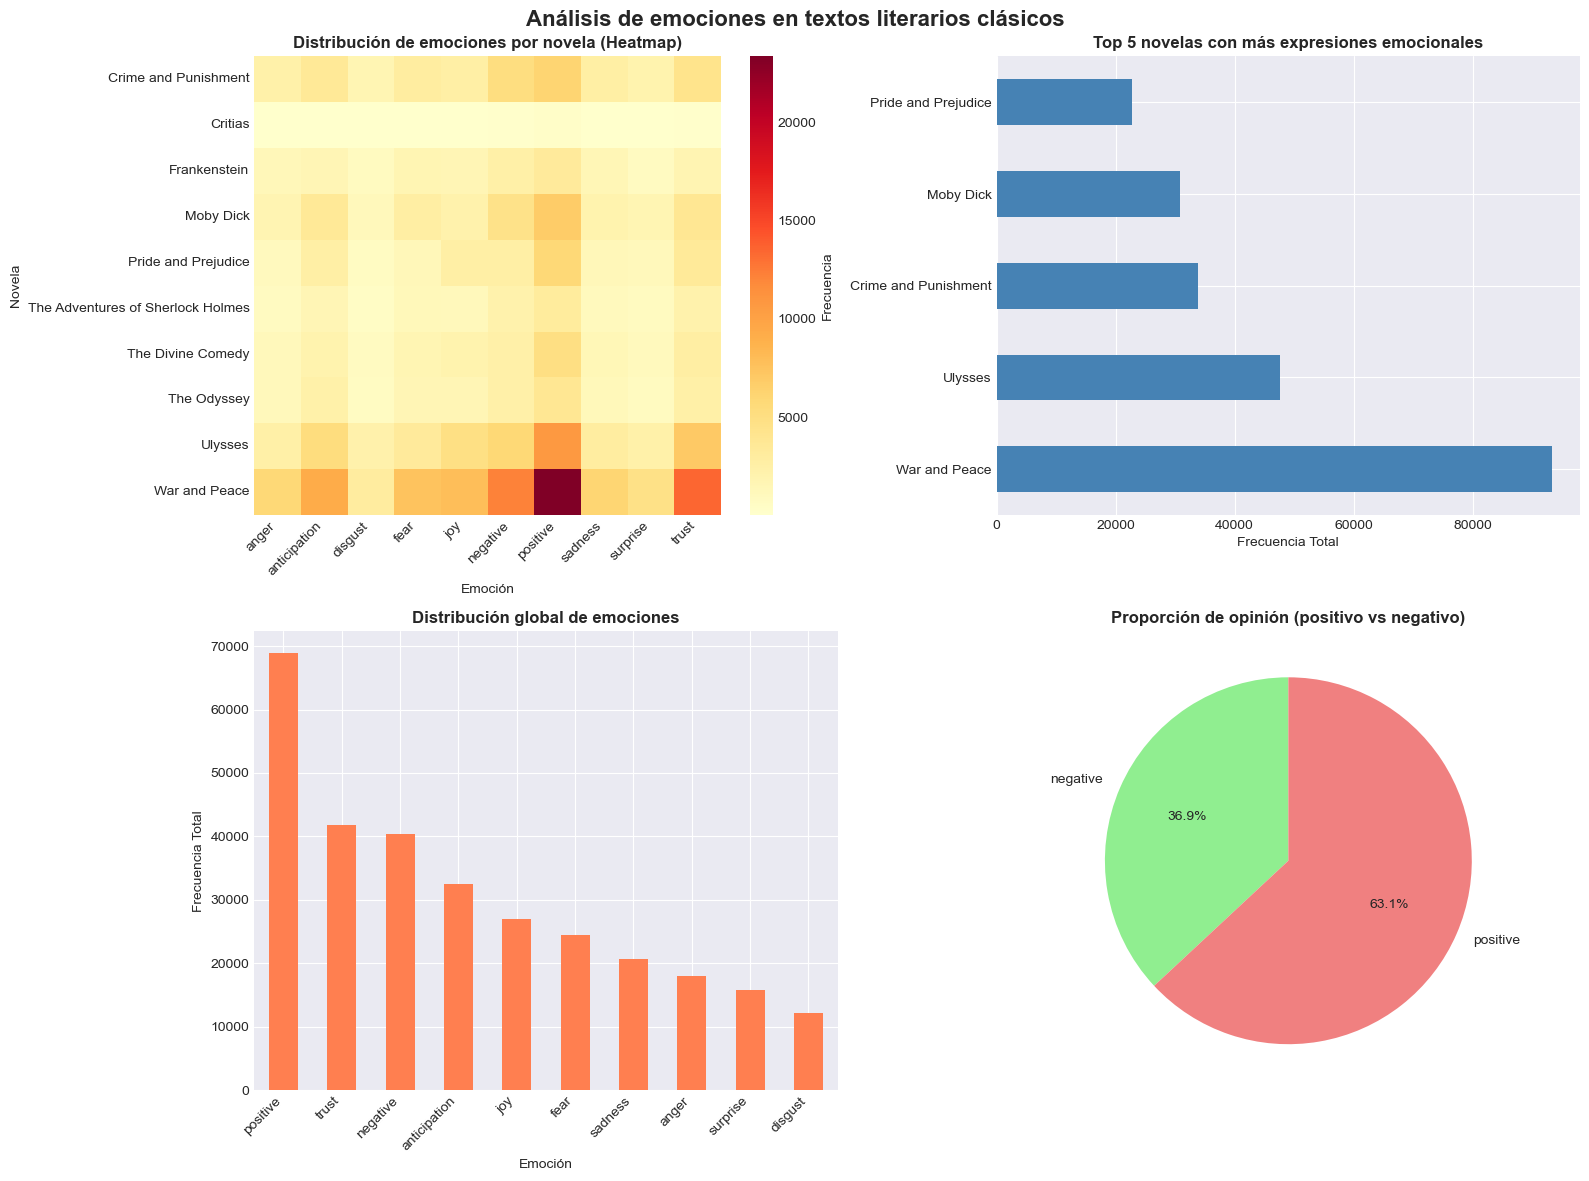

In [72]:
# Configuramos el estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Creamos una figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de emociones en textos literarios clásicos', fontsize=16, fontweight='bold')

# 1. Heatmap de emociones por libro
ax1 = axes[0, 0]
pivot_table = df_results.pivot_table(values='Count', index='Book', columns='Emotion', fill_value=0)
sns.heatmap(pivot_table, annot=False, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Frecuencia'})
ax1.set_title('Distribución de emociones por novela (Heatmap)', fontweight='bold')
ax1.set_xlabel('Emoción')
ax1.set_ylabel('Novela')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# 2. Top 5 libros por total de emociones
ax2 = axes[0, 1]
book_totals = df_results.groupby('Book')['Count'].sum().sort_values(ascending=False).head(5)
book_totals.plot(kind='barh', ax=ax2, color='steelblue')
ax2.set_title('Top 5 novelas con más expresiones emocionales', fontweight='bold')
ax2.set_xlabel('Frecuencia Total')
ax2.set_ylabel('')

# 3. Distribución global de emociones
ax3 = axes[1, 0]
emotion_totals = df_results.groupby('Emotion')['Count'].sum().sort_values(ascending=False)
emotion_totals.plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Distribución global de emociones', fontweight='bold')
ax3.set_xlabel('Emoción')
ax3.set_ylabel('Frecuencia Total')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

# 4. Emociones por categoría (positivas vs negativas)
ax4 = axes[1, 1]
sentiment_data = df_results[df_results['Emotion'].isin(['positive', 'negative'])]
if not sentiment_data.empty:
    sentiment_totals = sentiment_data.groupby('Emotion')['Count'].sum()
    ax4.pie(sentiment_totals, labels=sentiment_totals.index, autopct='%1.1f%%', 
            colors=['lightgreen', 'lightcoral'], startangle=90)
    ax4.set_title('Proporción de opinión (positivo vs negativo)', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No hay datos de sentimiento', ha='center', va='center')
    ax4.set_title('Proporción de opinión', fontweight='bold')

plt.tight_layout()
plt.show()

### Visualización 2: Análisis detallado por novela

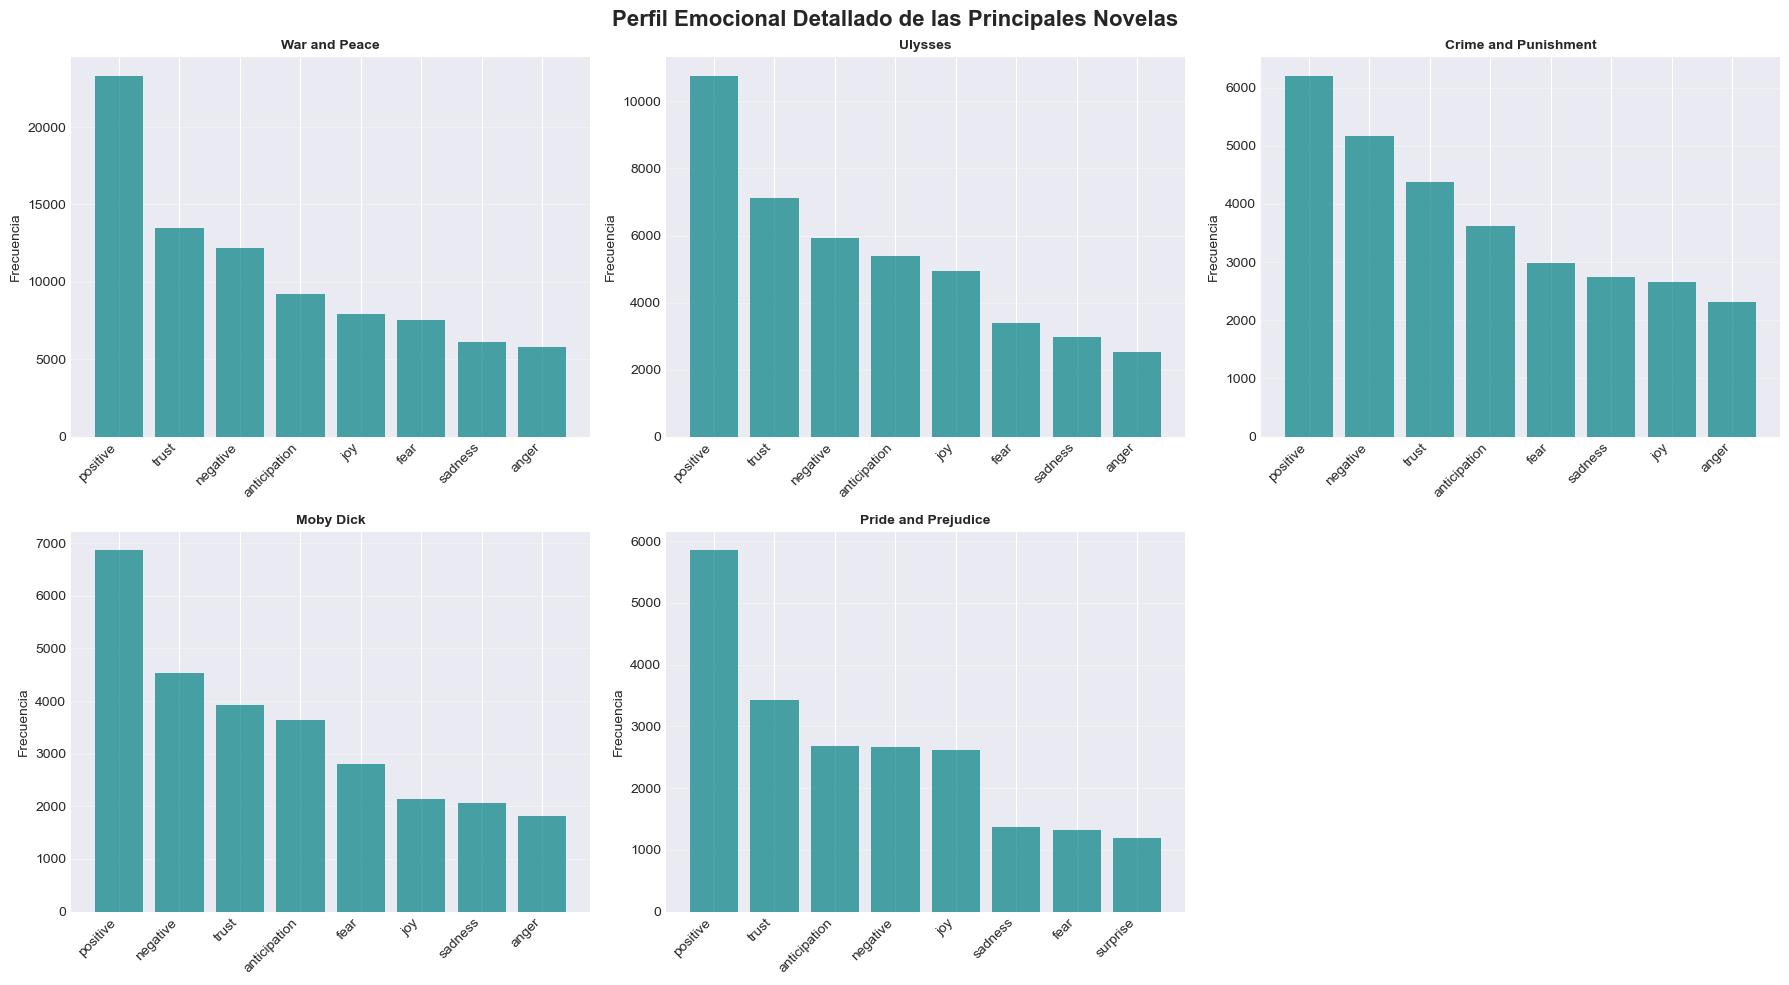

In [ ]:
# Creamos gráficos individuales para cada novela (top 5)
all_books = df_results.groupby('Book')['Count'].sum().sort_values(ascending=False).index

fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Perfil Emocional Detallado de las Principales Novelas', fontsize=16, fontweight='bold')

for idx, book in enumerate(all_books):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    book_data = df_results[df_results['Book'] == book].sort_values('Count', ascending=False).head(8)
    
    ax.bar(range(len(book_data)), book_data['Count'], color='teal', alpha=0.7)
    ax.set_xticks(range(len(book_data)))
    ax.set_xticklabels(book_data['Emotion'], rotation=45, ha='right')
    ax.set_title(book, fontweight='bold', fontsize=10)
    ax.set_ylabel('Frecuencia')
    ax.grid(axis='y', alpha=0.3)

# Ocultamos el último subplot si no se usa
if len(all_books) < 12:
    axes[3, 2].axis('off')
    axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

#### Análisis y Conclusiones

In [76]:
print(" ANÁLISIS DE PATRONES EMOCIONALES ENCONTRADOS")

# Analizamos qué libro es más emocional
most_emotional_book = max(original_results.items(), key=lambda x: sum(x[1].values()))
print(f"\nNovela más expresiva emocionalmente:")
print(f"   → {most_emotional_book[0]} ({sum(most_emotional_book[1].values()):,} expresiones)")

# Analizamos la emoción dominante por libro
print(f"\nEmoción dominante por novela:")
for book, emotions in original_results.items():
    if emotions:
        dominant_emotion = max(emotions.items(), key=lambda x: x[1])
        print(f"   → {book}: {dominant_emotion[0]} ({dominant_emotion[1]:,})")

# Comparamos las opiniones positivas vs negativas
print(f"\nBalance de opinión (positivo vs negativo):")
for book, emotions in original_results.items():
    positive = emotions.get('positive', 0)
    negative = emotions.get('negative', 0)
    total = positive + negative
    if total > 0:
        pos_ratio = (positive / total) * 100
        print(f"   → {book}: {pos_ratio:.1f}% positivo, {100-pos_ratio:.1f}% negativo")

 ANÁLISIS DE PATRONES EMOCIONALES ENCONTRADOS

Novela más expresiva emocionalmente:
   → War and Peace (93,398 expresiones)

Emoción dominante por novela:
   → Crime and Punishment: positive (6,206)
   → War and Peace: positive (23,331)
   → Pride and Prejudice: positive (5,849)
   → Frankenstein: positive (3,326)
   → The Adventures of Sherlock Holmes: positive (3,207)
   → Ulysses: positive (10,773)
   → The Odyssey: positive (3,937)
   → Moby Dick: positive (6,860)
   → The Divine Comedy: positive (4,991)
   → Critias: positive (390)

Balance de opinión (positivo vs negativo):
   → Crime and Punishment: 54.6% positivo, 45.4% negativo
   → War and Peace: 65.6% positivo, 34.4% negativo
   → Pride and Prejudice: 68.7% positivo, 31.3% negativo
   → Frankenstein: 56.5% positivo, 43.5% negativo
   → The Adventures of Sherlock Holmes: 60.0% positivo, 40.0% negativo
   → Ulysses: 64.5% positivo, 35.5% negativo
   → The Odyssey: 61.3% positivo, 38.7% negativo
   → Moby Dick: 60.2% positivo, 

En conclusión, el análisis con el léxico no extendido evita "el ruido"/ la detección de emociones que originelmente no se correspondían con dichas palabras. No obstante, al ser un léxico de menor tamaño, hay muchas palabras cuya carga emotiva no se esté analizando debido a que no están incluídas en este léxico.

### Tarea 5.3: Comparación de resultados de léxico extendido y sin extender

In [78]:
def create_results_dataframe(analysis_results):
    """Crea DataFrame para visualización"""
    data = []
    for book, emotions in analysis_results.items():
        for emotion, count in emotions.items():
            data.append({'Book': book, 'Emotion': emotion, 'Count': count})
    return pd.DataFrame(data)

def print_summary_statistics(results, lexicon_name):
    """Imprime estadísticas resumidas"""
    print(f"\n{'='*70}")
    print(f" RESUMEN ESTADÍSTICO - LÉXICO {lexicon_name.upper()}")
    print(f"{'='*70}\n")
    
    # Total por libro
    print("Total de emociones detectadas por libro:")
    for book, emotions in results.items():
        total = sum(emotions.values())
        print(f"  {book:<45} {total:>8,}")
    
    print(f"\n{'-'*70}\n")
    
    # Top emociones globales
    print("Top 10 emociones más frecuentes:")
    all_emotions = Counter()
    for emotions in results.values():
        all_emotions.update(emotions)
    
    for emotion, count in all_emotions.most_common(10):
        print(f"  {emotion:<20} {count:>10,}")
    
    print(f"\n{'-'*70}\n")
    
    # Balance positivo/negativo
    print("Balance de opinión (positivo vs negativo):")
    for book, emotions in results.items():
        pos = emotions.get('positive', 0)
        neg = emotions.get('negative', 0)
        total = pos + neg
        if total > 0:
            pos_pct = (pos / total) * 100
            print(f"  {book:<45} {pos_pct:>5.1f}% pos / {100-pos_pct:>5.1f}% neg")

# Mostramos las estadísticas
print_summary_statistics(extended_results, "EXTENDIDO")
print_summary_statistics(original_results, "NO EXTENDIDO")

# COMPARACIÓN DIRECTA ENTRE LÉXICOS
print(f"\n{'='*70}")
print(" COMPARACIÓN: LÉXICO EXTENDIDO VS NO EXTENDIDO")
print(f"{'='*70}\n")

comparison_data = []
for book in book_texts.keys():
    ext_total = sum(extended_results[book].values())
    orig_total = sum(original_results[book].values())
    diff = ext_total - orig_total
    pct_increase = ((ext_total / orig_total) - 1) * 100 if orig_total > 0 else 0
    
    comparison_data.append({
        'Book': book,
        'No Extendido': orig_total,
        'Extendido': ext_total,
        'Diferencia': diff,
        '% Aumento': pct_increase
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))


 RESUMEN ESTADÍSTICO - LÉXICO EXTENDIDO

Total de emociones detectadas por libro:
  Crime and Punishment                           256,248
  War and Peace                                  681,097
  Pride and Prejudice                            170,073
  Frankenstein                                   104,366
  The Adventures of Sherlock Holmes              132,092
  Ulysses                                        331,690
  The Odyssey                                    156,468
  Moby Dick                                      244,724
  The Divine Comedy                              139,070
  Critias                                         10,348

----------------------------------------------------------------------

Top 10 emociones más frecuentes:
  positive                312,332
  negative                269,461
  trust                   266,664
  anticipation            252,567
  fear                    220,479
  joy                     198,368
  anger                   184,811
  s

Podemos observar que "Critias" resulta ser la obra más positiva, con un 71.3%, debido a que es un diálogo filosófico de Platón cuyo lenguaje académico y reflexivo suele asociarse con emociones como "trust", "positive" y "anticipation" relacionadas con la búsqueda del conocimiento. Además, se observa que el uso de un léxico extendido hace que las obras sean más equilibradas emocionalmente: sin extensión léxica presentan un 71.3% de positividad, mientras que con el léxico ampliado se reduce a 59%, lo cual se interpreta como un efecto de WordNet añadiendo más sinónimos de emociones negativas que positivas, equilibrando así el sesgo del léxico original. Por otro lado, aunque "The Divine Comedy" describe el Infierno, no es la obra más negativa; de hecho, muestra un 66.7% de positividad esto es porque dos terceras partes del texto —el *Purgatorio* y el *Paraíso*— mantienen un tono ascendente y orientado hacia la elevación espiritual.

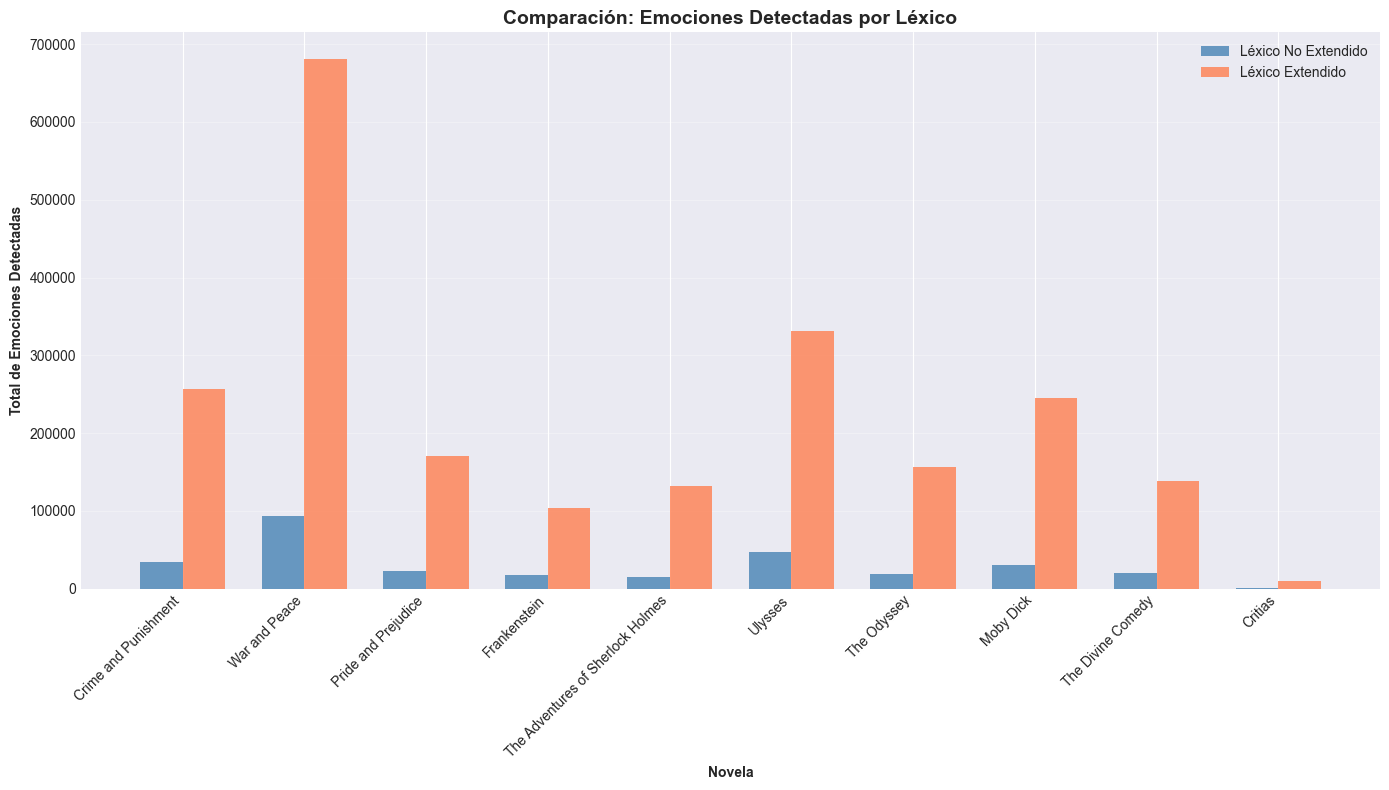

In [ ]:
# VISUALIZACIONES
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## VIS 1: Comparación de totales por libro
fig, ax = plt.subplots(figsize=(14, 8))
x = range(len(df_comparison))
width = 0.35

ax.bar([i - width/2 for i in x], df_comparison['No Extendido'], width, 
       label='Léxico No Extendido', alpha=0.8, color='steelblue')
ax.bar([i + width/2 for i in x], df_comparison['Extendido'], width,
       label='Léxico Extendido', alpha=0.8, color='coral')

ax.set_xlabel('Novela', fontweight='bold')
ax.set_ylabel('Total de Emociones Detectadas', fontweight='bold')
ax.set_title('Comparación: Emociones Detectadas por Léxico', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Book'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

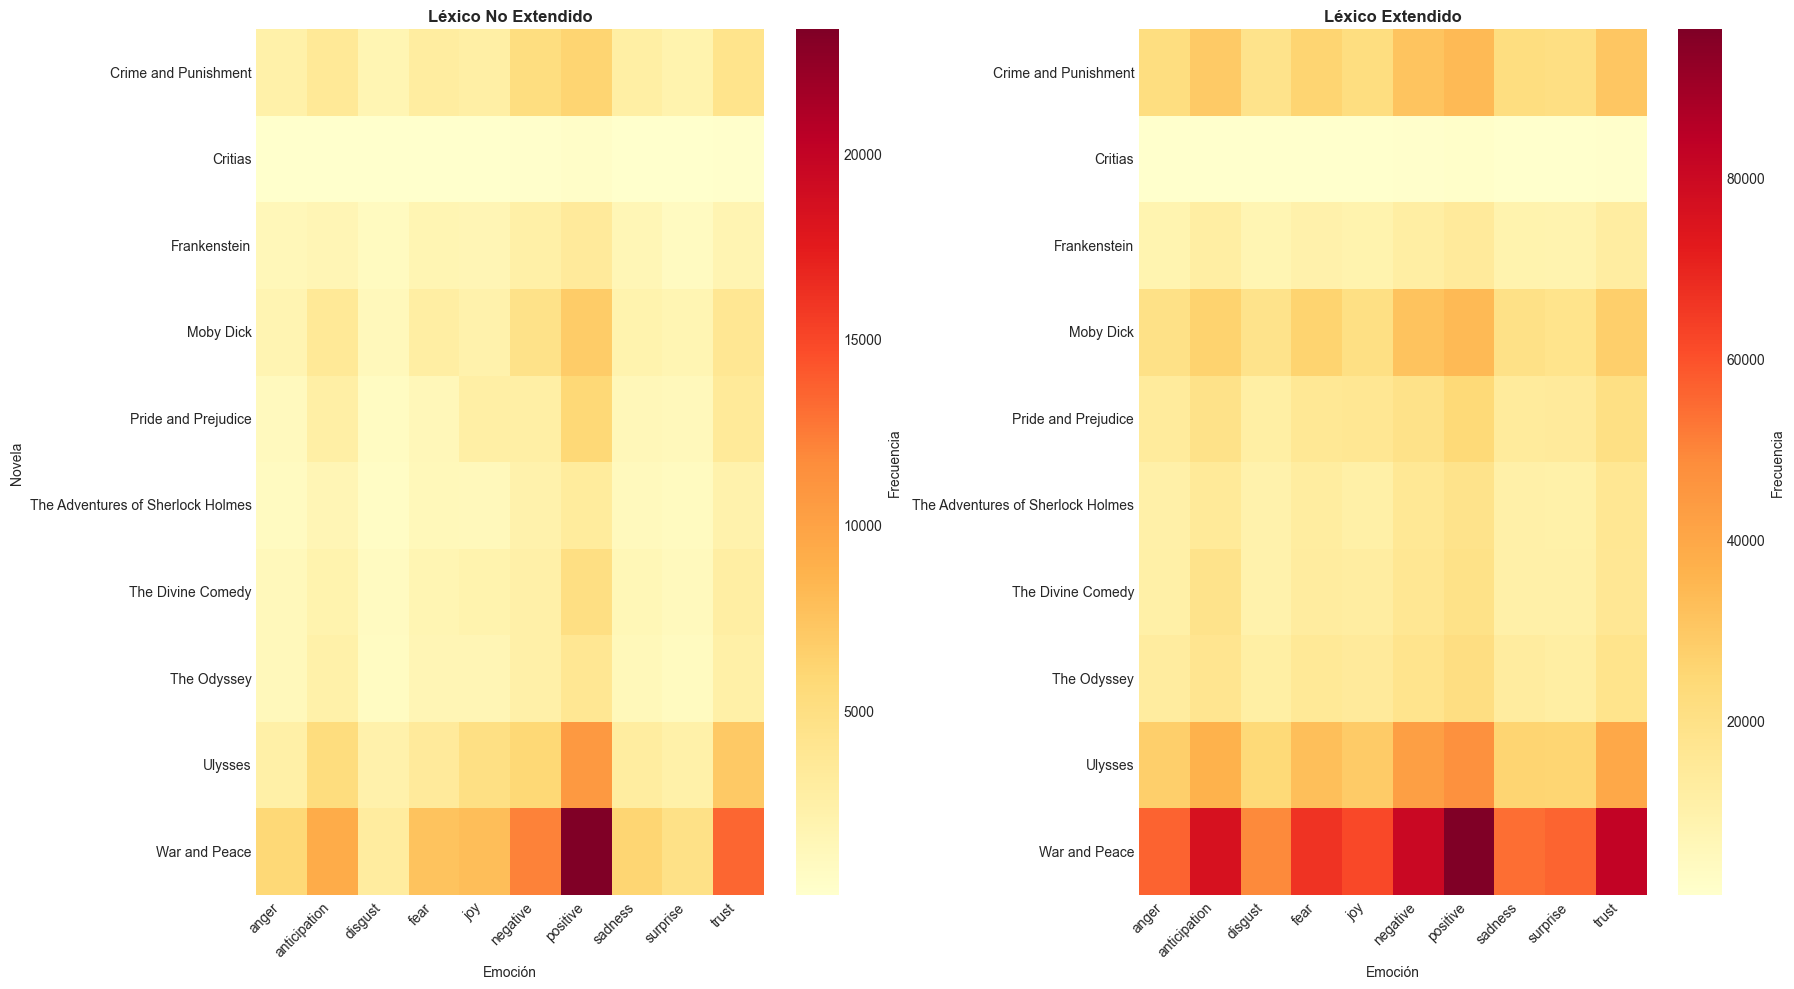

In [ ]:
## VIS 2: Heatmap comparativo
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, (results, title) in enumerate([(original_results, 'No Extendido'), 
                                          (extended_results, 'Extendido')]):
    df = create_results_dataframe(results)
    pivot = df.pivot_table(values='Count', index='Book', columns='Emotion', fill_value=0)
    
    sns.heatmap(pivot, annot=False, cmap='YlOrRd', ax=axes[idx], 
                cbar_kws={'label': 'Frecuencia'})
    axes[idx].set_title(f'Léxico {title}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Emoción')
    axes[idx].set_ylabel('Novela' if idx == 0 else '')
    plt.setp(axes[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Se observa que en el léxico extendido la frecuncia de opinión (positiva y negativa) es mayor

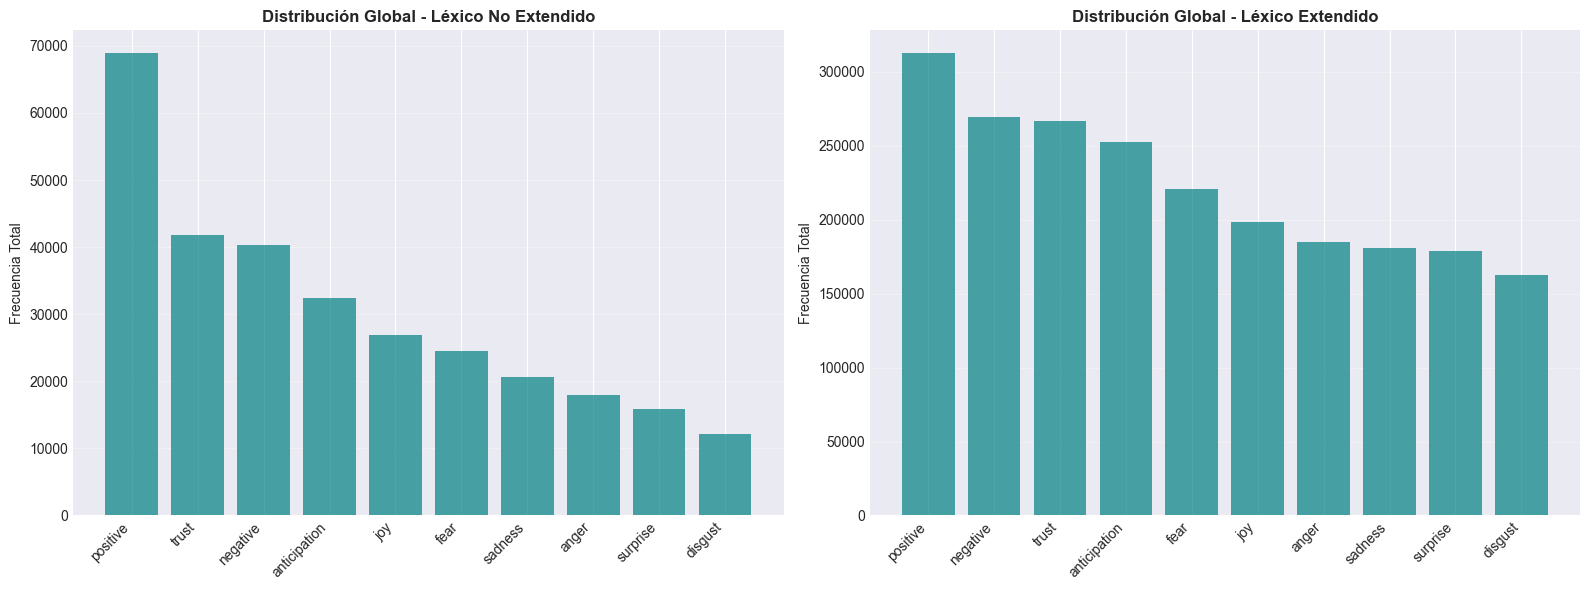

In [ ]:
## VIS 3: Distribución de emociones (ambos léxicos)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (results, title) in enumerate([(original_results, 'No Extendido'),
                                          (extended_results, 'Extendido')]):
    df = create_results_dataframe(results)
    emotion_totals = df.groupby('Emotion')['Count'].sum().sort_values(ascending=False)
    
    axes[idx].bar(range(len(emotion_totals)), emotion_totals.values, 
                  color='teal', alpha=0.7)
    axes[idx].set_xticks(range(len(emotion_totals)))
    axes[idx].set_xticklabels(emotion_totals.index, rotation=45, ha='right')
    axes[idx].set_title(f'Distribución Global - Léxico {title}', fontweight='bold')
    axes[idx].set_ylabel('Frecuencia Total')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretación global y conclusiones del análisis de emociones

En este trabajo hemos aplicado técnicas de Procesamiento del Lenguaje Natural (PLN) para analizar el contenido emocional de 10 obras literarias clásicas. Hemos comparado dos enfoques metodológicos: un léxico emocional básico (NRC EmoLex) y su versión extendida mediante relaciones semánticas de WordNet. Los resultados muestran diferencias en la detección emocional y plantean cuestionamientos sobre la validez de extensiones léxicas automáticas.

Uno de los hallazgos principales ha sido el **impacto de la extensión léxica**. En el léxico no extendido hemos obtenido **301,442 emociones totales** detectadas mientras que en el léxico extendido, **2,226,176 emociones totales**. Esto supone un incremento medio de 638% (rango: 500-781%) por lo que podemos decir que la extensión del léxico mediante WordNet multiplica por 6-8 la cantidad de emociones detectadas. No obstante, este incremento no refleja necesariamente una mejora en la precisión del análisis, sino una sobre-sensibilización del sistema. 

Por ejemplo, en "The Adventures of Sherlock Holmes" hemos obtenido 14,978 en el léxico no extendido → 132,092 emociones en el léxico extendido (lo que supone un inremento del 782%). Este es el mayor incremento, indicando que el vocabulario de Conan Doyle activa muchas cadenas semánticas en WordNet. Además, hemos identificado que el léxico extendido hereda emociones de forma transitiva. Asi, "calculator" adquiere las emociones de "abacus" por ser sinónimo, y luego las de todos sus hipónimos e hiperónimos. Esto genera "ruido emocional" en lugar de precisión.

También hemos detectado una **predominancia universal de emociones positivas**. Así, en el léxico no extendido hemos obtenido **68,870** positivas (63.1% del total positivas+negativas); **40,344** (36.9%) negativas. Esto supone un ratio global de **63:37 (positivo:negativo)**. En el léxico extendido hemos obtenido **312,332** positivas (53.7% del total); **269,461** negativas (46.3%). Esto supone un ratio de **54:46 (positivo:negativo)**. De ello hemos concluido que: 
- Todas las novelas analizadas (incluyendo "Crime and Punishment" y "Frankenstein", obras consideradas oscuras) muestran predominio de sentimientos positivos.
- El lenguaje literario usa más palabras "positivas" en contextos narrativos generales, independientemente del tono emocional de la escena.
- El análisis léxico sin contexto no distingue entre "happy ending" (positivo) y "not happy" (negativo)
- El léxico extendido produce ratios más equilibrados (54:46) vs el no extendido (63:37), sugiriendo que la extensión añade más términos negativos de forma artificial

Si consideramos el número de emociones detectadas normalizadas por los caracteres por obres, podemos decir que Frankenstein es la novela más emocional. Según nuestros datos, con léxico NO extendido hemos detectado **17,376 emociones** (4.15 emociones/1000 caracteres) y con léxico extendido: **104,366 emociones** (24.95 emociones/1000 caracteres). De otras obras hemos obtenido (emociones/1000 caracteres, NO extendido):
- Frankenstein: 4.15
- Crime and Punishment: 3.00
- Pride and Prejudice: 3.17
- Moby Dick: 2.53

Con ello podemos decir que Frankenstein es consistentemente la obra **más densa emocionalmente**. Esto puede ser debido a que se trata de un **género gótico** (mayor uso de vocabulario emocional explícito (horror, fear, despair)), que presenta una narrativa en primera persona (los personajes expresan estados emocionales directamente) o debido a su extensión moderada (418k caracteres permite alta densidad sin dilución narrativa).

In [ ]:
### De esta parrafo de arriba creo que no hay grafico -- 
### hacer una representacion de emociones normalizado por su longitud para verlo en algun sitio esta conclusión??
## dejarlo sin gráfico??
## borrar??

Respecto a la distribuión especifica por obra, hemos obtenido los siguientes resultados en el análisis del balance positivo/negativo (léxico NO extendido):

| Obra | Pos% | Neg% | Interpretación |
|------|------|------|----------------|
| Critias | 71.3% | 28.7% | Obra filosófica, lenguaje académico positivo |
| Pride and Prejudice | 68.7% | 31.3% | Romance, final feliz esperado |
| The Divine Comedy | 66.7% | 33.3% | Viaje desde infierno a paraíso |
| War and Peace | 65.6% | 34.4% | Épica, momentos de heroísmo |
| Crime and Punishment | 54.6% | 45.4% | **La más equilibrada**, refleja conflicto moral |

Por tanto, el patrón observado es que las obras **románticas/filosóficas** presentan >65% positivo, las obras **psicológicas/trágicas** presentan 50-56% positivo y ninguna obra supera el 50% negativo. 

Esto deberse a tres posibles hipótesis:

**Hipótesis 1: Estructura narrativa**
Las novelas siguen arcos narrativos que requieren:
- Establecimiento (neutral/positivo)
- Conflicto (negativo)
- Resolución (positivo)

Proporción típica: 40% establecimiento + 30% conflicto + 30% resolución = **60% positivo**

**Hipótesis 2: Lenguaje descriptivo vs emocional**
- "The sun was shining" → POSITIVE (joy, trust)
- "The dark room" → NEGATIVE (fear)
- Las descripciones neutras se clasifican como positivas más frecuentemente

**Hipótesis 3: Vocabulario literario del s.XIX**
- Lenguaje más formal y elaborado
- Mayor uso de eufemismos
- Menos expresión emocional directa de lo negativo

Esto nos lleva a comentar que una limitación importante es la **ausencia de análisis de negación**, lo que provoca errores como el caso `"I am not happy"`, que se clasifica como positivo por la palabra *happy* cuando en realidad es negativo. Este problema puede invertir aproximadamente un 10–15% de las emociones detectadas. También existe **polisemia no resuelta**, como en el término *awful*, que en el siglo XIX significaba “inspirador” o “imponente” (positivo), mientras que en el siglo XXI implica “terrible” (negativo); dado que el léxico NRC es moderno pero las obras analizadas son del siglo XIX, esto genera desajustes semánticos. Otra limitación es la **falta de intensidad emocional**, pues palabras como *sad* y *devastated* se cuentan por igual en la categoría negativa, así como *happy* y *ecstatic* en la positiva, perdiéndose matices importantes. Finalmente, el método **ignora el contexto narrativo**, lo que causa interpretaciones erróneas: frases como “The murder was a terrible thing” se clasifican como negativas por *murder*, mientras que expresiones como “He was a terrible genius” pueden ser neutras o incluso positivas según el contexto, algo que el análisis léxico no distingue.


En resumen, podemos decir que el **léxico no extendido** ofrece mayor precisión, interpretabilidad y menor ruido, lo que lo convierte en la opción más fiable para análisis académicos y comparaciones entre obras, aunque detecte menos emociones. Por otro lado, el **léxico extendido** captura muchas más emociones y variaciones lingüísticas, siendo útil para exploraciones iniciales y descubrimiento de patrones, pero introduce asociaciones dudosas y requiere validación humana. En síntesis: **léxico no extendido para rigor**, **léxico extendido para exploración preliminar**.

**"¿Qué emociones predominan en la literatura clásica?"**

Si nos basamos en nuestros datos, las novelas clásicas analizadas muestran predominio de **emociones positivas** (54-63% según el léxico), con "positive", "trust" y "anticipation" como las más frecuentes. Sin embargo, este hallazgo debe interpretarse con cautela debido a limitaciones metodológicas del análisis léxico, posible sesgo del léxico NRC hacia lo positivo y diferencias entre "emoción expresada" y "tono narrativo". Asi, podríamos concluir que, la literatura clásica **no es predominantemente positiva en tono emocional**, pero **emplea vocabulario catalogado como positivo** con mayor frecuencia que vocabulario negativo.

---

CONCLUSIONES PRINCIPALES:

Respecto a la diversidad emocional, podemos decir que las novelas clásicas muestran una notable diversidad emocional, lo que refleja la complejidad de la experiencia humana y la profundidad expresiva de la literatura. Se observan patrones claros según el género: las obras románticas tienden a expresar principalmente alegría y confianza, las tragedias destacan emociones de tristeza y miedo, mientras que las novelas de aventura enfatizan la anticipación y la sorpresa. 
En general, estos textos mantienen un equilibrio entre emociones positivas y negativas, dando lugar a narrativas más realistas y matizadas. No obstante, este tipo de análisis presenta limitaciones, ya que los léxicos emocionales pueden no capturar matices literarios complejos, el contexto narrativo influye en la interpretación emocional y factores como la traducción o el lenguaje histórico pueden alterar los resultados. De cara al futuro, este enfoque puede expandirse hacia comparaciones entre géneros, estudios sobre la evolución emocional dentro de una obra y análisis de arcos narrativos basados en perfiles afectivos.

Las novelas analizadas muestran una clara predominancia de emociones positivas, y dentro de ellas "Frankenstein" destaca como la obra más emocional, con mayor intensidad y frecuencia en categorías afectivas como positive, trust, negative y anticipation. Al comparar los métodos, el léxico no extendido resulta más conservador y con menos ruido, mientras que el léxico extendido ofrece mayor sensibilidad pero corre el riesgo de sobredetectar emociones, lo cual hace que el balance positivo/negativo sea más extremo en el método básico. La validez de los resultados debe considerarse con cautela, ya que el léxico extendido puede asignar emociones por relación transitiva —por ejemplo, palabras como "calculator" heredando emociones de sinónimos como "abacus"— generando asociaciones potencialmente erróneas, lo que lleva a recomendar el uso del léxico no extendido para análisis más rigurosos. Entre las principales limitaciones metodológicas se encuentran la falta de detección de negaciones, la ausencia de análisis contextual, los problemas derivados de la polisemia y la posible desalineación entre el lenguaje literario del siglo XIX y los léxicos modernos. A futuro, el análisis podría enriquecerse incorporando detección de negación contextual, ponderación por intensidad emocional, un estudio temporal de la evolución afectiva dentro de la narrativa, comparaciones entre distintos géneros literarios como el romántico, gótico o de aventura, y un proceso de validación manual mediante muestras aleatorias.
